In [1]:
from landslide4sense.models import Unet
from landslide4sense.data import LandslideDataSet
from landslide4sense.utils.tools import eval_image
from landslide4sense.utils import set_deterministic
from landslide4sense.models import Unet
from landslide4sense import EPSILON
from landslide4sense.experiments import (
    setup_model,
    setup_datasets
)


import random
import sys

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from torch.nn import Upsample, CrossEntropyLoss

import omegaconf
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cfg = omegaconf.OmegaConf.load("../conf/config.yaml")
set_deterministic(cfg.train.seed)
cfg 

{'data': {'dir': '${hydra:runtime.cwd}/data/', 'train_list': '${hydra:runtime.cwd}/data/train.txt', 'eval_lists_paths': ['${hydra:runtime.cwd}/data/train.txt'], 'eval_names': ['train'], 'test_list': '${hydra:runtime.cwd}/data/valid.txt', 'input_size': [128, 128], 'augmentation': {'module': 'landslide4sense.data.augmentations', 'name': 'transforms'}}, 'model': {'restore_from': None, 'module': 'segmentation_models_pytorch', 'name': 'UnetPlusPlus', 'args': {'in_channels': 14, 'encoder_name': 'resnet101', 'encoder_weights': 'imagenet', 'decoder_attention_type': 'scse', 'classes': 2}}, 'optimizer': {'restore_from': None, 'module': 'torch.optim', 'name': 'Adam', 'args': {'lr': 0.001, 'weight_decay': 0.0005}}, 'loss': {'module': 'landslide4sense.losses', 'name': 'Sum', 'args': {'weights': [0.5, 0.5], 'losses_cfg': [{'module': 'segmentation_models_pytorch.losses', 'name': 'DiceLoss', 'args': {'ignore_index': 255, 'mode': 'multiclass'}}, {'module': 'torch.nn', 'name': 'CrossEntropyLoss', 'args'

In [13]:
model = setup_model(cfg)
print(model)
state_dict = torch.load(
    "../models/drawn-cherry-59/epoch_28_train_f1=74.239/model.pth", 
    map_location=torch.device(device)
)
model.load_state_dict(state_dict)
model = model.to(device)
interp = torch.nn.Upsample(size=(128, 128), mode="bilinear")

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(14, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [75]:
train_dataset = LandslideDataSet(
    "../data/",
    "../data/train.txt",
    max_iters=1,
    set="labeled",
)

train_loader: DataLoader[LandslideDataSet] = DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=cfg.train.num_workers,
    pin_memory=True,
)

In [76]:
model.eval()
all_preds = []
all_labels = []
pbar = tqdm(
    enumerate(train_loader),
    desc=f"Evaluating on val...",
    total=len(train_loader),
)

for i, batch in pbar:
    image, label, _, name = batch
    label = label.squeeze().numpy().astype(np.uint8)
    image = image.float().to(device)

    with torch.no_grad():
        pred = model(image)

    pred = interp(F.softmax(pred, dim=1)).half().detach()
    all_preds.append(pred)
    all_labels.append(label)

Evaluating on val...:   0%|          | 0/38 [00:00<?, ?it/s]/opt/conda/envs/landslide/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
Evaluating on val...: 100%|██████████| 38/38 [00:42<00:00,  1.12s/it]


In [77]:
preds = torch.cat(all_preds).cpu().numpy()
print("preds shape", preds.shape)
labels = np.concatenate(all_labels)
labels.shape

preds shape (3800, 2, 128, 128)


(3800, 128, 128)

In [78]:
def evaluate(y_pred, y_true):
    TP, FP, TN, FN, n_valid_sample = eval_image(
        y_pred.astype(np.uint8).squeeze().reshape(-1) , 
        y_true.astype(np.uint8).squeeze().reshape(-1), 
        2
    )

    OA = np.sum(TP[1]) * 1.0 / n_valid_sample
    P = np.squeeze((TP[1] * 1.0) / (TP[1] + FP[1] + EPSILON))
    R = np.squeeze((TP[1] * 1.0) / (TP[1] + FN[1] + EPSILON))
    F1 = (2.0 * P * R) / (P + R + EPSILON)
    return OA, P, R, F1

In [79]:
num_classes = 2
num_thresholds = 100

def initialize_arrays(num: int, size: int):
    arrays = []
    for _ in range(num):
        arrays.append(np.zeros((size, 1)))
    return arrays

thrs, f1s, ps, rs, oas = initialize_arrays(5, num_thresholds)

for i, thr in tqdm(enumerate(np.linspace(.1, .9, num_thresholds)), total=num_thresholds):
    y_pred = (preds[:, 1, :, :] > thr)
    OA, P, R, F1 = evaluate(y_pred, labels)
    thrs[i] = thr
    oas[i] = OA
    ps[i] = P
    rs[i] = R
    f1s[i] = F1

100%|██████████| 100/100 [04:46<00:00,  2.86s/it]


In [80]:
best_idx = f1s.argmax()
optimal_thr = np.squeeze(thrs[best_idx])
optimal_thr 

array(0.47979798)

In [81]:
best_f1 = f1s.max()
best_f1

0.742414652600671

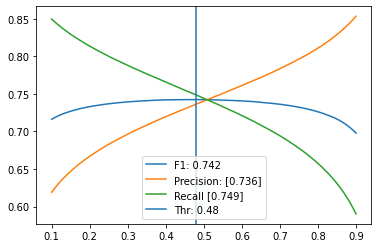

In [82]:
plt.plot(thrs, f1s, label=f"F1: {np.round(best_f1, 3)}")
plt.plot(thrs, ps, label=f"Precision: {np.round(ps[best_idx], 3)}")
plt.plot(thrs, rs, label=f"Recall {np.round(rs[best_idx], 3)}")
#plt.xlim(optimal_thr - .3, optimal_thr + .3)
plt.axvline(optimal_thr, label=f"Thr: {np.round(optimal_thr, 2)}")
plt.legend()
plt.show()

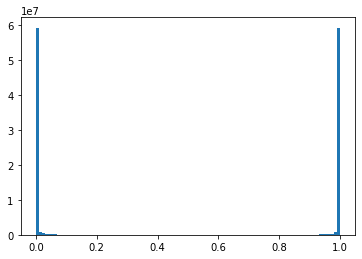

In [83]:
plt.hist(preds.squeeze().reshape(-1), bins=100)
plt.show()

# Visualiation

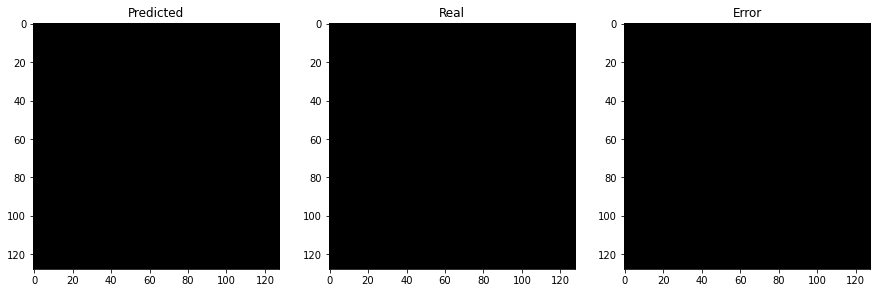

In [85]:
index = 5

predicted = (preds[index, 1, ...] > optimal_thr).astype('uint8')
real = labels[index, ...]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].imshow(predicted, cmap="gray")
ax[0].set_title("Predicted")

ax[1].imshow(real, cmap="gray")
ax[1].set_title("Real")

error = np.zeros((*real.shape, 3))

error[..., 0] = (real != predicted)
error[..., 1] = (real == 1) & (real == predicted)
ax[2].imshow(error)
ax[2].set_title("Error")

plt.show()

## How many no-mask images do the dataset have?

In [18]:
train_dataset = LandslideDataSet(
    "../data/",
    "../data/train.txt",
    max_iters=1,
    set="labeled",
)

train_loader: DataLoader[LandslideDataSet] = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=cfg.train.num_workers,
    pin_memory=True,
)

In [19]:
zeros = 0
pbar = tqdm(
    enumerate(train_loader),
    desc=f"Evaluating on train...",
    total=len(train_loader),
)
clean_names = []
zero_mask_names = []

for i, batch in pbar:
    image, label, _, name = batch
    pixel_sum = label.sum()
    if pixel_sum == 0:
        zeros += 1
        zero_mask_names.append(name[0])
    else:
        clean_names.append(name[0])
    perc = (zeros / (i+1)) * 100
    perc = round(perc, 2)
    pbar.set_description(f"perc. of zeros = {perc}%")

perc. of zeros = 41.26%: 100%|██████████| 3800/3800 [01:03<00:00, 59.91it/s]


In [20]:
random.shuffle(zero_mask_names)

In [23]:
desired_perc_zero_mask = 0.1
num_selected_zero_mask = int((desired_perc_zero_mask * len(clean_names)) / (1 - desired_perc_zero_mask))
num_selected_zero_mask

248

In [24]:
selected_zero_mask_names = zero_mask_names[:num_selected_zero_mask]

In [25]:
cleaned_names = selected_zero_mask_names + clean_names

In [27]:
len(selected_zero_mask_names) / len(cleaned_names)

0.1

In [28]:
random.shuffle(cleaned_names)

In [29]:
with open("/content/drive/MyDrive/data_science_projects/landslide4sense-2022/data/train_cleaned.txt", "w") as f:
    for name in cleaned_names:
        f.write(name + "\n")

In [30]:
len(cleaned_names)

2480

In [32]:
train_dataset = LandslideDataSet(
    "../data/",
    "../data/train_cleaned.txt",
    max_iters=1,
    set="labeled",
)

train_loader: DataLoader[LandslideDataSet] = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=cfg.train.num_workers,
    pin_memory=True,
)

zeros = 0
pbar = tqdm(
    enumerate(train_loader),
    desc=f"Evaluating on train...",
    total=len(train_loader),
)
clean_names = []
zero_mask_names = []

for i, batch in pbar:
    image, label, _, name = batch
    pixel_sum = label.sum()
    if pixel_sum == 0:
        zeros += 1
        zero_mask_names.append(name[0])
    else:
        clean_names.append(name[0])
    perc = (zeros / (i+1)) * 100
    perc = round(perc, 2)
    pbar.set_description(f"perc. of zeros = {perc}%")

2232